In [1]:
#!pip install matplotlib
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as f

In [3]:
spark = SparkSession.builder.master("local[*]").getOrCreate()

### Load Data

In [4]:
raw_train_df = spark.read.option('header', 'true').csv('../data/raw/train.csv')\
    .select('id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'trip_duration')\
    .withColumn('vendor_id', f.col('vendor_id').cast('int'))\
    .withColumn('pickup_datetime',  f.to_timestamp(f.col('pickup_datetime'), 'YYYY-MM-dd HH:mm:ss'))\
    .withColumn('dropoff_datetime',  f.to_timestamp(f.col('dropoff_datetime'), 'YYYY-MM-dd HH:mm:ss'))\
    .withColumn('passenger_count', f.col('passenger_count').cast('int'))\
    .withColumnRenamed('pickup_longitude', 'pickup_lon')\
    .withColumn('pickup_lon', f.col('pickup_lon').cast('double'))\
    .withColumnRenamed('pickup_latitude', 'pickup_lat')\
    .withColumn('pickup_lat', f.col('pickup_lat').cast('double'))\
    .withColumnRenamed('dropoff_longitude', 'dropoff_lon')\
    .withColumn('dropoff_lon', f.col('dropoff_lon').cast('double'))\
    .withColumnRenamed('dropoff_latitude', 'dropoff_lat')\
    .withColumn('dropoff_lat', f.col('dropoff_lat').cast('double'))\
    .withColumn('trip_duration', f.col('trip_duration').cast('int'))\

raw_train_df.printSchema()
raw_train_df.show(2)

root
 |-- id: string (nullable = true)
 |-- vendor_id: integer (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- pickup_lon: double (nullable = true)
 |-- pickup_lat: double (nullable = true)
 |-- dropoff_lon: double (nullable = true)
 |-- dropoff_lat: double (nullable = true)
 |-- trip_duration: integer (nullable = true)

+---------+---------+-------------------+-------------------+---------------+------------------+------------------+------------------+------------------+-------------+
|       id|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|        pickup_lon|        pickup_lat|       dropoff_lon|       dropoff_lat|trip_duration|
+---------+---------+-------------------+-------------------+---------------+------------------+------------------+------------------+------------------+-------------+
|id2875421|        2|2015-12-27 17:24:55|2015-12-

### Trips by date

In [24]:
# raw_train_df\
# .withColumn('date', f.to_date(f.col('pickup_datetime')))\
# .groupby('date').count()\
# .show()

# raw_train_df\
# .sort(f.asc('pickup_datetime'))\
# .show(5)
# raw_train_df\
# .sort(f.desc('pickup_datetime'))\
# .show(5)

# raw_train_df\
# .withColumn('date', f.to_date(f.col('pickup_datetime')))\
# .show()
#.groupby('date').count()\
raw_train_df.select(f.date_format('pickup_datetime','yyyy-MM').alias('month')).groupby('month').count().show()

+-------+-------+
|  month|  count|
+-------+-------+
|2015-12|1458644|
+-------+-------+



### Trips by hour

In [8]:
trips_by_hour_df_pd = raw_train_df\
.withColumn('hour', f.hour(f.col('pickup_datetime')))\
.groupby('hour').count()\
.sort(f.asc('hour'))\
.toPandas().set_index('hour')

In [ ]:
trips_by_hour_df_pd.plot()

## Distribution by trip duration

In [8]:
clean_train_df_pd = raw_train_df.groupby('trip_duration').count().sort(f.asc('trip_duration')).toPandas().set_index('trip_duration')

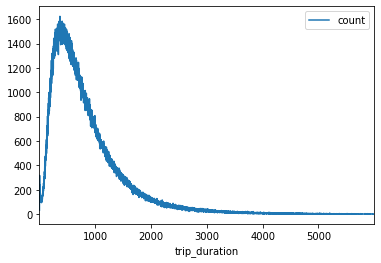

In [9]:
clean_train_df_pd[(clean_train_df_pd.index > 0) & (clean_train_df_pd.index < 6000)].plot()


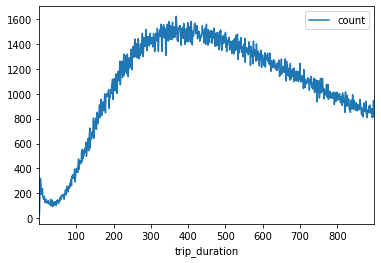

In [10]:
clean_train_df_pd[(clean_train_df_pd.index > 0) & (clean_train_df_pd.index < 900)].plot()

In [11]:
len(clean_train_df_pd) , len(clean_train_df_pd[(clean_train_df_pd.index > 90) & (clean_train_df_pd.index < 6000)])

(7417, 5560)

In [12]:
raw_train_df.where(f.col('trip_duration') > 90).where(f.col('trip_duration') < 7200).count()

1440592

In [13]:
raw_train_df.where(f.col('trip_duration') > 90).where(f.col('trip_duration') < 3600).count()

1430511

### Mean trip duration by vendor_id

In [14]:
raw_train_df.groupby('vendor_id').agg(f.mean('trip_duration')).show()

+---------+------------------+
|vendor_id|avg(trip_duration)|
+---------+------------------+
|        1| 845.4382435408687|
|        2|1058.6431638006823|
+---------+------------------+



### Clean data

In [15]:
clean_train_df = raw_train_df\
.dropna(subset=['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_lon', 'pickup_lat', 'dropoff_lon', 'dropoff_lat', 'trip_duration'])\
.where(f.col('passenger_count') > 0)\
.where(f.col('trip_duration') > 0)\
.where(f.col('trip_duration') > 90).where(f.col('trip_duration') < 7200)

clean_train_df.count()

1440578

### Feature engineering

In [16]:
import s2sphere
from pyspark.sql.types import StringType

def cell_id(level: int, lat: int, lng: int) -> str:
    return s2sphere.CellId.from_lat_lng(s2sphere.LatLng.from_degrees(lat, lng)).parent(level).to_token()

cell_id_udf = f.udf(cell_id, StringType())

In [17]:
clean_train_df\
.withColumn('cell_l12', cell_id_udf(f.lit(12), f.col('pickup_lon'), f.col('pickup_lat')))\
.withColumn('cell_l18', cell_id_udf(f.lit(18), f.col('pickup_lon'), f.col('pickup_lat')))\
.drop('vendor_id')\
.show(5)

+---------+-------------------+-------------------+---------------+------------------+------------------+------------------+------------------+-------------+--------+----------+
|       id|    pickup_datetime|   dropoff_datetime|passenger_count|        pickup_lon|        pickup_lat|       dropoff_lon|       dropoff_lat|trip_duration|cell_l12|  cell_l18|
+---------+-------------------+-------------------+---------------+------------------+------------------+------------------+------------------+-------------+--------+----------+
|id2875421|2015-12-27 17:24:55|2015-12-27 17:32:30|              1| -73.9821548461914| 40.76793670654297|-73.96463012695312|40.765602111816406|          455| b0fdf7f|b0fdf7e2cf|
|id2377394|2015-12-27 00:43:35|2015-12-27 00:54:38|              1|-73.98041534423828|40.738563537597656|-73.99948120117188| 40.73115158081055|          663| b0fdf7f|b0fdf7e6bf|
|id3858529|2015-12-27 11:35:24|2015-12-27 12:10:48|              1| -73.9790267944336|40.763938903808594|-74.0